# Feature selection, modeling, parameter tuning

## Prepare notebook

Import libraries and functions

In [1]:
from imblearn.over_sampling import SMOTE 
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import random
import seaborn as sns
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import sys
import os
sys.path.append('../src/features')
from build_features import get_dummies
sys.path.append('../src/models')
from predict_model import clint_scorer, trump_scorer, avg_scorer
#warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
seed = 20

Load predictors (no dummy variables yet) and target variable

In [3]:
# with open('../data/processed/predictors.pickle', 'rb') as file:
#     X = pickle.load(file)
with open('../data/processed/predictors_not_dummies.pickle', 'rb') as file:
    X_no = pickle.load(file)
with open('../data/processed/target.pickle', 'rb') as file:
    y = pickle.load(file)

## Split data into train and test sets

In [4]:
X_train_rfe, X_test_rfe, y_train_rfe, y_test_rfe = train_test_split(X_no, y, test_size=0.2, random_state=20)

## Define performance metrics 

Create a custom scorer to pass to sklearn cross validator 

In [5]:
clinton_metric = make_scorer(clint_scorer)
trump_metric = make_scorer(trump_scorer)
comb_metric = make_scorer(avg_scorer)

## Define models 

Set up basic model objects

In [6]:
lr = LogisticRegression(
    C=2, penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000, random_state=20)
rf = RandomForestClassifier(n_estimators=100, random_state=20)
knn = KNeighborsClassifier()
svm = SVC(kernel='linear', random_state=20)

##  Evaluate training performance of basic models

Create a list of model names and model variables 

In [7]:
name_list = ['Logistic regression', 'Random forest',
             'K-nearest neighbors', 'Support vector machine']
model_list = [lr, rf, knn, svm]

Run cross validation on all basic models and score using Clinton metric 

In [8]:
for idx, model in enumerate(model_list):
    clint_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=clinton_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ":", clint_scores, 'Mean:', round(clint_scores.mean(), 5))

Logistic regression : [90.4 90.2 90.2 88.3 89.5] Mean: 89.72
Random forest : [88.8 89.3 88.8 88.3 90. ] Mean: 89.04
K-nearest neighbors : [87.2 87.  88.1 84.9 87.4] Mean: 86.92
Support vector machine : [90.7 91.3 90.9 88.8 90.6] Mean: 90.46


Run cross validation on all basic models and score using Trump metric

In [9]:
for idx, model in enumerate(model_list):
    trump_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=trump_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ':', trump_scores, 'Mean:', round(trump_scores.mean(), 5))

Logistic regression : [87.3 88.7 83.4 86.9 88. ] Mean: 86.86
Random forest : [89.3 91.4 84.1 87.8 87.7] Mean: 88.06
K-nearest neighbors : [84.1 86.9 80.7 86.4 83.4] Mean: 84.3
Support vector machine : [86.2 88.2 82.6 86.2 87.5] Mean: 86.14


Run cross validation on all basic models for combined metric 

In [10]:
for idx, model in enumerate(model_list):
    comb_scores = cross_val_score(
        model, X_train_rfe, y_train_rfe, cv=5, scoring=comb_metric, n_jobs=-1)
    name = name_list[idx]
    print(name, ':', comb_scores,'Mean:', comb_scores.mean())

Logistic regression : [88.85 89.45 86.8  87.6  88.75] Mean: 88.29
Random forest : [89.05 90.35 86.45 88.05 88.85] Mean: 88.55
K-nearest neighbors : [85.65 86.95 84.4  85.65 85.4 ] Mean: 85.60999999999999
Support vector machine : [88.45 89.75 86.75 87.5  89.05] Mean: 88.3


### RFE

Recursive feature engineering on top performing basic models using combined metric and print optimal number of features found using each model 

In [11]:
selector_lr = RFECV(lr, step=1, min_features_to_select=1,  #logistic regression rfe
                    scoring=comb_metric, cv=5) 
selector_lr.fit(X_train_rfe, y_train_rfe)  # 
selector_rf = RFECV(rf, step=1, min_features_to_select=1,  #random forest rfe
                    scoring=comb_metric, cv=5)
selector_rf.fit(X_train_rfe, y_train_rfe)
print('Optimal number of LR features: {}'.format(selector_lr.n_features_))
print('Optimal number of RF features: {}'.format(selector_rf.n_features_))

Optimal number of LR features: 7
Optimal number of RF features: 22


Print the list of selected features from the logistic regression basic model

In [12]:
rank_list = selector_lr.ranking_
feature_ranks = []
nt_slct_rank_feat = []
slct_rank_feat = []
for idx, rank in enumerate(rank_list):
    feature_ranks.append([rank, X_train_rfe.columns[idx]])
for list in feature_ranks:
    if list[0] != 1:
        nt_slct_rank_feat.append(list)
    if list[0] == 1:
        slct_rank_feat.append(list)
print('Not selected:' '\n', nt_slct_rank_feat, '\n')
print('Selected:''\n', slct_rank_feat) 

Not selected:
 [[3, 'imiss_a_2016'], [9, 'imiss_b_2016'], [5, 'imiss_d_2016'], [6, 'imiss_e_2016'], [2, 'imiss_g_2016'], [12, 'imiss_h_2016'], [4, 'imiss_i_2016'], [17, 'imiss_j_2016'], [14, 'imiss_k_2016'], [16, 'imiss_m_2016'], [11, 'imiss_n_2016'], [10, 'imiss_o_2016'], [7, 'imiss_q_2016'], [15, 'imiss_r_2016'], [8, 'imiss_s_2016'], [13, 'imiss_t_2016']] 

Selected:
 [[1, 'imiss_c_2016'], [1, 'imiss_f_2016'], [1, 'imiss_l_2016'], [1, 'imiss_p_2016'], [1, 'imiss_u_2016'], [1, 'imiss_x_2016'], [1, 'imiss_y_2016']]


In [13]:
slctd_feat = []
for item in slct_rank_feat:
    slctd_feat.append(item[1])
slctd_feat
selected_feat = X_no[slctd_feat]
with open('../data/processed/selected_feat.pickle', 'wb') as file:
    pickle.dump(selected_feat, file)

Visualize features versus grid scores

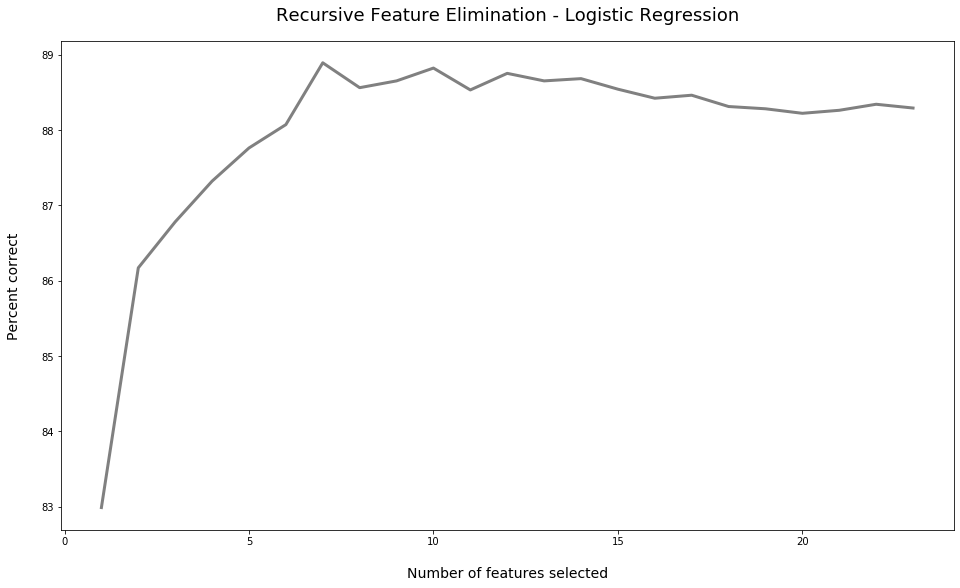

In [14]:
plt.figure(figsize=(16, 9))
line_plt = sns.lineplot(range(1, len(selector_lr.grid_scores_) + 1), selector_lr.grid_scores_, color='grey', linewidth=3)
line_plt.set_title('Recursive Feature Elimination - Logistic Regression', pad=20, fontsize=18)
line_plt.set_xlabel('Number of features selected', fontsize=14, labelpad=20)
line_plt.set_ylabel('Percent correct', fontsize=14, labelpad=20)
plt.show()

Drop the features that were not selected from the predictors dataframe 

In [15]:
np.where(selector_lr.support_ == False)[0]
X_selected = X_no.drop(X_no.columns[np.where(selector_lr.support_ == False)[0]], axis=1)

In [16]:
print(len(X_selected.columns))
X_selected.head()

7


,imiss_c_2016,imiss_f_2016,imiss_l_2016,imiss_p_2016,imiss_u_2016,imiss_x_2016,imiss_y_2016
0,1.0,2.0,1.0,2.0,2.0,1.0,1.0
1,2.0,1.0,4.0,1.0,2.0,3.0,4.0
2,2.0,1.0,1.0,2.0,2.0,1.0,2.0
3,3.0,2.0,2.0,3.0,2.0,2.0,3.0
4,1.0,1.0,4.0,1.0,1.0,1.0,1.0


### Define post-RFE X with dummy variables

Use one hot encoding to transform the selected X features into dummy variables 

In [17]:
X = get_dummies(X_selected)
len(X.columns)

28

### Create new train and test split on final features

Using the selected features that are now one-hot encoded, create a new train and test set 

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=20)

## Parameter tuning

Define parameter grid for random forest and run grid search cross validation

In [19]:
rf_2 = RandomForestClassifier(n_estimators=100, random_state=20)
param_grid = {'n_estimators': [100], 'max_depth': [
    1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'oob_score': [True], 'max_features': [None, 'sqrt']}
grid = GridSearchCV(rf_2, param_grid, iid=True, cv=5, n_jobs=-1,scoring=comb_metric, verbose=1, return_train_score=True)

Fit to training data and print best parameters and best score 

In [20]:
grid.fit(X_train, y_train)
print(grid.best_params_)
print(round(grid.best_score_, 3))

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   27.9s finished


{'max_depth': 8, 'max_features': 'sqrt', 'n_estimators': 100, 'oob_score': True}
88.23


In [21]:
lr_2 = LogisticRegression(
    C=2, penalty='l2', solver='lbfgs', multi_class='auto', max_iter=1000, random_state=20)
lr_2.fit(X_train, y_train)
print(lr_2.coef_[0])
print(lr_2.classes_)
print(lr_2.intercept_)

[ 0.48877986  0.62768315  0.52136256  0.0258593   0.24179532  0.27629528
  0.47687267  0.05204736 -0.70764685 -1.61337127 -2.07573083 -0.42357228
  0.50387637  0.82441948  0.45695833  0.36399887  0.51252507  1.0311067
  1.42274503  0.32268765 -0.4659145  -0.96576947 -1.26200044 -0.3471488
 -0.53114176 -0.7799944  -0.88764071 -0.50293407]
[1. 2. 3.]
[ 0.74793993 -0.22699382 -0.5209461 ]


In [22]:
predictions_lr_2 = lr_2.predict(X_train)
scores_lr_2 = cross_validate(lr_2, X_train, y_train, scoring=comb_metric, cv=5)
scores_lr_2['test_score']

array([90.8 , 90.7 , 87.35, 88.95, 89.3 ])

### Use SMOTE TO oversample minority class

In [23]:
print('Before oversampling, counts of label 1: {}'.format(sum(y_train == 1))) 
print('Before oversampling, counts of label 2: {}'.format(sum(y_train == 2))) 
print('Before oversampling, counts of label 3: {}'.format(sum(y_train == 3))) 

Before oversampling, counts of label 1: 2810
Before oversampling, counts of label 2: 2795
Before oversampling, counts of label 3: 795


In [24]:
sm = SMOTE(random_state = 20) 
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train) 

In [25]:
print('After oversampling, the shape of train_X: {}'.format(X_train_sm.shape)) 
print('After oversampling, the shape of train_y: {} \n'.format(y_train_sm.shape)) 
print('After oversampling, counts of label 1: {}'.format(sum(y_train_sm == 1))) 
print('After oversampling, counts of label 2: {}'.format(sum(y_train_sm == 2))) 
print('After oversampling, counts of label 3: {}'.format(sum(y_train_sm == 3))) 

After oversampling, the shape of train_X: (8430, 28)
After oversampling, the shape of train_y: (8430,) 

After oversampling, counts of label 1: 2810
After oversampling, counts of label 2: 2810
After oversampling, counts of label 3: 2810


In [26]:
lr_sm = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=1000) 
lr_sm.fit(X_train_sm, y_train_sm) 
scores_lr_sm = cross_val_score(lr_sm, X_train_sm, y_train_sm, cv=5, scoring=comb_metric, n_jobs=-1)
scores_lr_sm

array([82.75, 80.05, 76.  , 76.9 , 77.75])

In [27]:
grid_sm = GridSearchCV(rf_2, param_grid, iid=True, cv=5, n_jobs=-1,scoring=comb_metric, verbose=1, return_train_score=True)
grid_sm.fit(X_train_sm, y_train_sm)
print(grid_sm.best_params_)
print(grid_sm.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   34.4s finished


{'max_depth': 2, 'max_features': None, 'n_estimators': 100, 'oob_score': True}
83.05999999999997


## Evaluate test performance

Evaluate performance of the RF model found using grid search then applying SMOTE to it 

In [28]:
scores_rf = cross_validate(grid_sm, X_test, y_test, scoring=comb_metric, cv=5)
scores_rf['test_score'].mean()

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   11.6s finished


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   12.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    9.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   10.6s finished


88.58

Evaluate performance of logistic regression model w/o SMOTE on test data

In [29]:
predictions_lr2 = lr_2.predict(X_test)
scores_lr2 = cross_validate(lr_2, X_test, y_test, scoring=comb_metric, cv=5)
scores_lr2['test_score'].mean()

88.96000000000001

Evaluate performance of logistic regression model with SMOTE on test data 

In [30]:
predictions_sm2 = lr_sm.predict(X_test)
scores_lr_sm = cross_validate(lr_sm, X_test, y_test, scoring=comb_metric, cv=5)
scores_lr_sm['test_score'].mean()

89.46000000000001

In [31]:
pip install joblib

Note: you may need to restart the kernel to use updated packages.


In [32]:
import joblib

In [33]:
joblib.dump(lr_sm, '../src/models/clf.pkl', compress=1)

['../src/models/clf.pkl']

In [34]:
joblib.dump(lr_2, '../src/models/clf_2.pkl', compress=1)

['../src/models/clf_2.pkl']